# Vežbe 2 - OCR (Optical character recognition)

Cilj ovih vežbi je implementacija osnovne verzije OCR-a i upoznavanje sa Keras okruženjem za rad sa neuronskim mrežama.

* Keras - Python biblioteka za laku implementaciju neuronski mreža (http://keras.io/)



### Tok aktivnosti implementacije OCR - a 

Tok aktivnosti predstavlja korake koje je potrebno izvršiti prilikom implementacije OCR-a.

<img src="images/Tok aktivnosti.png">

### Početak implementacije
Skup biblioteka sa prethodnih vežbi smo proširili Keras bibliotekom za rad sa neuronskim mrežama.

In [2]:
#import potrebnih biblioteka
%matplotlib inline
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
import collections

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

## Korak 1 - 3
Ovi koraci su detaljno objašnjeni na prethodnim vežbama, tako da neće biti dodatno objašnjavani

In [3]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

### Korak 4 -  izdvajanje regiona od interesa

U ovom koraku potrebno je izdvojiti samo regione(konture) od interesa. Potrebno je označiti regione od interesa na slici i napraviti listu slika od regiona koja će kasnije biti ulaz za neuronsku mrežu.

### TODO 1
Za potrebe TODO 1 implementirati funkciju za promenu veličine slike na 28 x 28. Ovo se radi kako bi svi regioni koje ćemo koristiti za neuronsku mrežu bili iste veličine. *(pomoć: pogledati OpenCV funkciju resize)*

In [4]:
# TODO 1 
def resize_region(region):
    '''Transformisati selektovani region na sliku dimenzija 28x28'''
    
    return cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)

# TODO 1 test
todo_1_img = load_image('images/todo_1_test.png')
todo_1_ref = (28,28)
todo_1_res = resize_region(todo_1_img).shape[0:2]
print 'TODO 1 test passed:', todo_1_res == todo_1_ref

TODO 1 test passed: True


### TODO 2
* Označiti regione od interesa na originalnoj slici.
* Za svaki region napraviti posebnu sliku dimenzija 28 x 28. 
* Za označavanje regiona koristiti metodu cv2.boundingRect(contour).
* Kao povratnu vrednost vratiti originalnu sliku na kojoj su obeleženi regioni (koristiti OpenCV funkciju **rectangle**) i niz slika koje predstavljaju regione sortirane  po rastućoj vrednosti x ose

In [5]:
# TODO 2
def select_roi(image_orig, image_bin):
    '''Oznaciti regione od interesa na originalnoj slici. (ROI = regions of interest)
        Za svaki region napraviti posebnu sliku dimenzija 28 x 28. 
        Za označavanje regiona koristiti metodu cv2.boundingRect(contour).
        Kao povratnu vrednost vratiti originalnu sliku na kojoj su obeleženi regioni
        i niz slika koje predstavljaju regione sortirane po rastućoj vrednosti x ose
    '''
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = [] # lista sortiranih regiona po x osi (sa leva na desno)
    
    regions_dic = {}
    for contour in contours: 
        x,y,w,h = cv2.boundingRect(contour) #koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        if area > 100 and h < 100 and h > 15 and w > 20:
            # kopirati [y:y+h+1, x:x+w+1] sa binarne slike i smestiti u novu sliku
            # označiti region pravougaonikom na originalnoj slici (image_orig) sa rectangle funkcijom
            region=image_bin[y:y+h+1,x:x+w+1]
            regions_dic[x] = resize_region(region)   
            cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,255,0),2)
            
    sorted_regions_dic = collections.OrderedDict(sorted(regions_dic.items()))
    sorted_regions = sorted_regions_dic.values()        
    # sortirati sve regione po x osi (sa leva na desno) i smestiti u promenljivu sorted_regions
    return image_orig, sorted_regions
    

## Korak 5

Regioni od interesa su predstavljeni vektorom čiji su elementi matrice dimenzija 28x28. Elementi matrica su vrednosti 0 ili 255. Potrebno je skalirati vrednosti elemenata matrice na opseg od 0 do 1, kako bi se pogodio linearni deo sigmoid funkcije i smanjilo vreme obučavanja.
Nakon skaliranja matrice je potrebno transformisati u vektor od 784 elementa.

###TODO 3

Skalirati sve elemente matrice sa celobrojnog opsega [0, 255] na realni opseg [0, 1].

In [6]:
# TODO 3
def scale_to_range(image): # skalira elemente slike na opseg od 0 do 1
    ''' Elementi matrice image su vrednosti 0 ili 255. 
        Potrebno je skalirati sve elemente matrica na opseg od 0 do 1
    '''
    return image/255

# TODO 3 test
todo_3_matrix = np.array([[0, 255], [51, 153]], dtype='float')
todo_3_ref = np.array([[0., 1.], [0.2, 0.6]], dtype='float')
todo_3_res = scale_to_range(todo_3_matrix)
print 'TODO 3 test passed:', np.array_equal(todo_3_res, todo_3_ref)

TODO 3 test passed: True


###TODO 4

Region koji je zapravo slika (matrica) dimenzija 28x28 transformiati u vektor od 784 elementa.

In [7]:
# TODO 4
def matrix_to_vector(image):
    '''Sliku koja je zapravo matrica 28x28 transformisati u vektor sa 784 elementa'''
    return image.flatten()

# TODO 4 test
todo_4_image = np.ndarray((28,28))
todo_4_ref = (784L,)
todo_4_res = matrix_to_vector(todo_4_image).shape
print 'TODO 4 test passed:', todo_4_res == todo_4_ref

TODO 4 test passed: True


###TODO 5

Svaki region pripremiti za ulaz na neuronsku mrežu: skaliranje elemenata na [0,1] i transformaciju u vektor.

In [8]:
# TODO 5
def prepare_for_ann(regions):
    '''Regioni su matrice dimenzija 28x28 čiji su elementi vrednosti 0 ili 255.
        Potrebno je skalirati elemente regiona na [0,1] i transformisati ga u vektor od 784 elementa '''
    ready_for_ann = []
    for region in regions:
        # skalirati elemente regiona (metoda iz TODO 3 scale_to_range)
        # region sa skaliranim elementima pretvoriti u vektor (metoda iz TODO 4 matrix_to_vector)
        # vektor dodati u listu spremnih regiona
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
        
    return ready_for_ann

###TODO 6

Konvertovati alfabet u niz pogodan za obučavanje NM, odnosno niz čiji su svi elementi 0 osim elementa čiji je indeks jednak indeksu elementa iz alfabeta za koji formiramo niz.
Primer prvi element iz alfabeta [1,0,0,0,0,0,0,0,0,0], za drugi [0,1,0,0,0,0,0,0,0,0] itd..

In [9]:
# TODO 6
def convert_output(alphabet):
    '''Konvertovati alfabet u niz pogodan za obučavanje NM,
        odnosno niz čiji su svi elementi 0 osim elementa čiji je
        indeks jednak indeksu elementa iz alfabeta za koji formiramo niz.
        Primer prvi element iz alfabeta [1,0,0,0,0,0,0,0,0,0],
        za drugi [0,1,0,0,0,0,0,0,0,0] itd..
    '''
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

# TODO 6 test
test_6_alphabet = [0, 1, 2]
test_6_ref = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype='float')
test_6_res = convert_output(test_6_alphabet).astype('float')
print 'TODO 6 test passed:', np.array_equal(test_6_res, test_6_ref)

TODO 6 test passed: True


##Korak 6

### Neuronska mreža

Veštačka neuronska mreža se sastoji od 784 ulazna neurona, 128 neurona u skrivenom sloju i 10 neurona na izlazu. Zašto baš 784 neurona na ulazu i 10 neurona na izlazu? Regione smo transformisali prvo na matricu dimenzija 28x28,a zatim u vektor od 784 elementa. Što se tiče 10 neurona na izlazu, to je posledica broja znakova u alfabetu. U našem primeru alfabet (0,1,2,3,4,5,6,7,8,9) ima 10 elemenata pa nam je potrebno 10 neurona na izlazu.
Neuronska mreža je implementirana pomoću Keras biblioteke.
<img src="images/neuronska_mreza.png">

### Sigmoidalna aktivaciona funkcija
$ sigm(x) = \dfrac{1}{1 + e^{-x}} $

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/2000px-Logistic-curve.svg.png" width="300" height="300">

In [10]:
def create_ann():
    '''Implementacija veštačke neuronske mreže sa 784 neurona na uloznom sloju,
        128 neurona u skrivenom sloju i 10 neurona na izlazu. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    ann.add(Dense(10, activation='sigmoid'))
    return ann
    
def train_ann(ann, X_train, y_train):
    '''Obucavanje vestacke neuronske mreze'''
    X_train = np.array(X_train, np.float32) # dati ulazi
    y_train = np.array(y_train, np.float32) # zeljeni izlazi za date ulaze
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=2000, batch_size=1, verbose = 0, shuffle=False, show_accuracy = False) 
      
    return ann

##Korak 7 - određivanje pobedničkog neurona

Određivanje pobedničkog neurona. Pobednički neuron je neuron čija je aktivaciona vrednost najveća. Npr. ako imamo dva neurona sa aktivacionim vrednostima 0.3 i 0.89, pobednik je drugi sa aktivacijom 0.89.

##TODO 7

Pronaći indeks neurona koji je najviše pobuđen.


In [11]:
# TODO 7
def winner(output): # output je vektor sa izlaza neuronske mreze
    '''pronaći i vratiti indeks neurona koji je najviše pobuđen'''
    return max(enumerate(output), key=lambda x: x[1])[0]

# TODO 7 test
todo_7_output = [0., 0.2, 0.3, 0.95]
todo_7_ref = 3
todo_7_res = winner(todo_7_output)
print 'TODO 7 test passed:', todo_7_res == todo_7_ref

TODO 7 test passed: True


##Korak 8 - prikaz rezultata

Pikazati rezultat prepoznavanja neuronske mreže. Za svaki rezultat pronaći indeks pobedničkog  neurona koji ujedno predstavlja i indeks prepoznatog elementa u alfabetu. Dodati karakter iz alfabeta u result

In [12]:
def display_result(outputs, alphabet):
    '''za svaki rezultat pronaći indeks pobedničkog
        regiona koji ujedno predstavlja i indeks u alfabetu.
        Dodati karakter iz alfabet u result'''
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

## Start
Učitati sliku za obučavanje veštačke neuronske mreže. Transformisati sliku i binarni oblik i označiti regione od interesa (u ovom slučaju to su brojevi od 0 do 9).
Prikazati sliku sa označenim regionima od interesa.

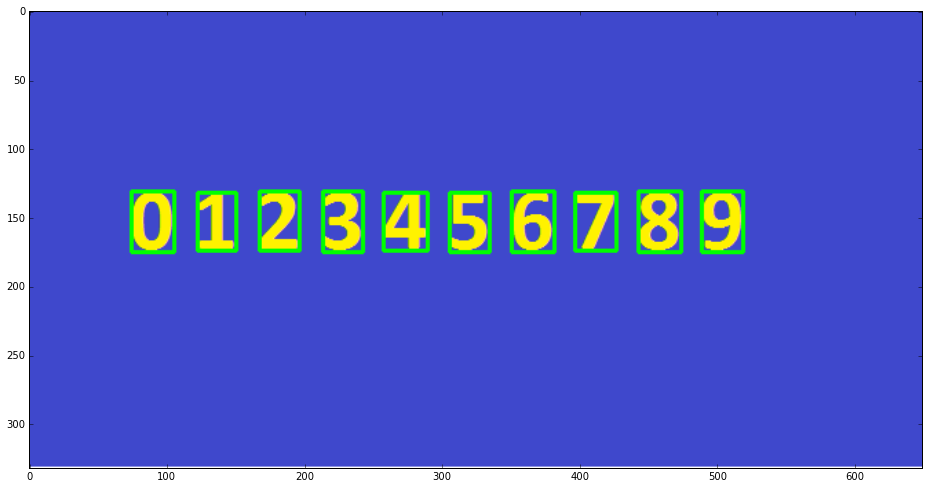

In [13]:
image_color = load_image('images/brojevi.png')
img = invert(image_bin(image_gray(image_color)))
img_bin = erode(dilate(img))
selected_regions, numbers = select_roi(image_color.copy(), img)
display_image(selected_regions)

In [14]:
# insert alphabet here
alphabet = [0,1,2,3,4,5,6,7,8,9]

In [16]:
inputs = prepare_for_ann(numbers)
outputs = convert_output(alphabet)
ann = create_ann()
ann = train_ann(ann, inputs, outputs)

KeyboardInterrupt: 

### Verifikacija i primer predikcije

Za verifikaciju obučenosti neuronske mreže ćemo uzeti drugi i treći ulazni vektor (brojevi 3 i 4 iz alfabeta).
Metoda **model.predict** kao ulazni parametar prima niz vektora dimenzija 784.
Rezultat **predict** metode je niz vektora dimenzije 10, koji sadrži koeficijente pobuđenosti.

In [ ]:
result = ann.predict(np.array(inputs[2:4], np.float32))
print result
print display_result(result, alphabet)

## TODO 8

Učitati sliku za testiranje rada OCR -a  'images/test.png'. Transformisati sliku u oblik pogodan za ulaz u neuronsku mrežu. 
Prikazati rezultate predikcije kao i sliku sa označenim regionima od interesa.

PSEUDO KOD:
* učitati sliku 'images/test.png'
* pretvoriti sliku u binarnu i ako je potrebno invertovati je
* ako je potrebno primeniti eroziju i/ili diletaciju
* selektovati regione od značaja
* pripremiti podatke za ulaz na NM
* pozvati metodu **predict**, a kao parametar proslediti pripremljene podatke
* prikazati rezultate predikcije


In [ ]:
# TODO 8
test=load_image('images/test.png')
#display_image(test)
test_bin=invert(image_bin(image_gray(test)))
#display_image(test_bin)
test_bin=erode(dilate(test_bin))
#display_image(test_bin)
selected_test, test_numbers = select_roi(test.copy(),test_bin)
#display_image(selected_test)
inputs=prepare_for_ann(test_numbers)
result=ann.predict(np.array(inputs,np.float32))
print display_result(result,alphabet)
display_image(test)

### TODO dodatno

Implementirati kalkulator. Alfabet za kalkulator i test primeri se nalaze u 'images/kalkulator_alfabet.png'.

In [ ]:
# TODO dodatno - kalkulator